# Things to install

## Colab

In [55]:
#!apt update && apt install -y openslide-tools
#!pip install openslide-python

## Locale

In [56]:
#!pip install openslide-python
#!pip install opencv-python

# Code

## Imports and env var

In [57]:
import openslide
import cv2
from matplotlib import pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

path_to_image = "../slides/RECHERCHE-010.svs"
path_to_xml = "../annotations/RECHERCHE-010.xml"
output_width = 2000
output_height = 2000

## Functions

In [58]:
def get_annotatios(file_path):
    # Parsa il file XML delle annotazioni
    tree = ET.parse(file_path)
    root = tree.getroot()
    # Ottieni tutte le annotazioni dal file XML
    annotations = []
    for annotation in root.iter('Annotation'):
        name = annotation.get('Name')
        coordinates = []
        for coordinate in annotation.iter('Coordinate'):
            x = float(coordinate.get('X'))
            y = float(coordinate.get('Y'))
            coordinates.append((x, y))
        annotations.append({'name': name, 'coordinates': coordinates})
    return annotations


In [59]:
def is_mostly_white(image, threshold_w=0.85, threshold_p = 0.98):
    # Converti l'immagine in scala di grigi
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calcola la soglia per considerare i pixel bianchi
    pixel_threshold = int(threshold_w * 255)

    # Conta i pixel bianchi nell'immagine
    white_pixels = np.sum(gray_image >= pixel_threshold)

    # Calcola la percentuale di pixel bianchi rispetto alla dimensione totale dell'immagine
    white_percentage = white_pixels / (gray_image.shape[0] * gray_image.shape[1])

    # Verifica se la percentuale di pixel bianchi supera la soglia
    if white_percentage >= threshold_p:
        return True, white_percentage
    else:
        return False, white_percentage

In [72]:
def get_labels(labels, annotations):
    for annotation in annotations:
        polygon = np.array([annotation['coordinates']], dtype=np.int32)
        cv2.fillPoly(labels, polygon, 1)

## 'Main'

In [73]:
# Carica l'immagine svs
wsi = openslide.OpenSlide(path_to_image)
# Ottieni le dimensioni dell'immagine
w, h = wsi.dimensions
# Calcola il numero di righe e colonne necessarie per suddividere l'immagine
num_rows = h // output_height
num_cols = w // output_width

In [74]:
annotations = get_annotatios(path_to_xml)
# Crea un'immagine di output con le stesse dimensioni dell'immagine svs
labels = np.zeros((h, w), dtype=np.uint8)
get_labels(labels, annotations)

3 58 False percentuale 0.32073175


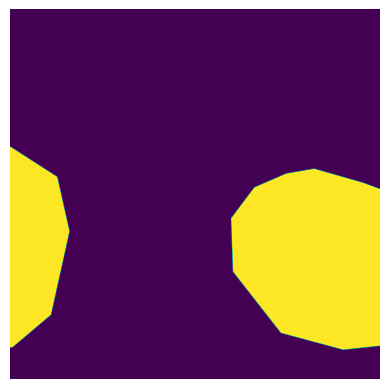

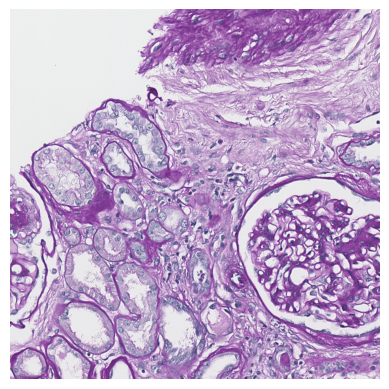

3 59 False percentuale 0.2421335


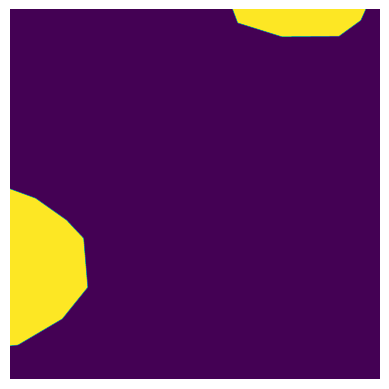

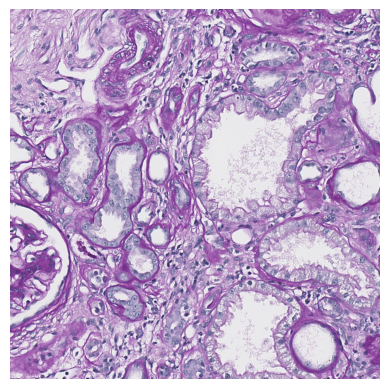

4 58 False percentuale 0.21886375


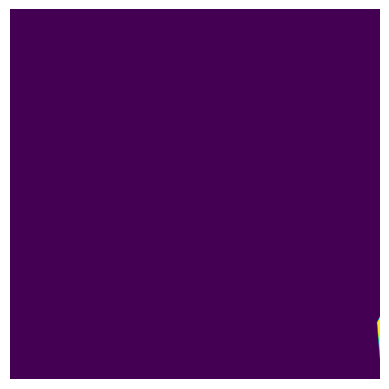

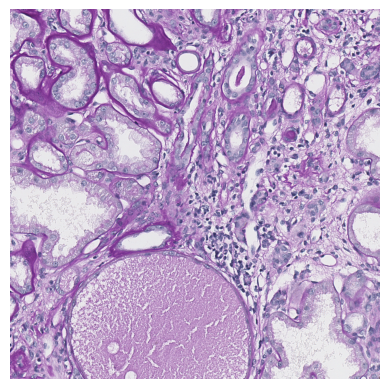

4 59 False percentuale 0.19815775


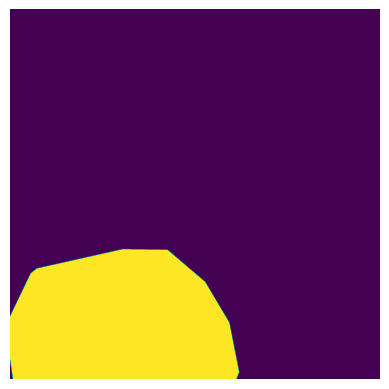

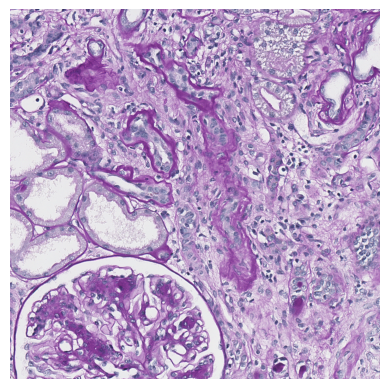

In [76]:
#for row in range(num_rows):
#    for col in range(num_cols):
for row in range(3, 5):
    for col in range(58, 60):
        # Calcola le coordinate di inizio e fine per l'immagine corrente
        x = col * output_width
        y = row * output_height
        x_end = x + output_width
        y_end = y + output_height
        
        # Estrai l'immagine corrente
        region = wsi.read_region((x, y), 0, (output_width, output_height))
        image = cv2.cvtColor(np.array(region), cv2.COLOR_RGBA2BGR)
        
        is_white, p = is_mostly_white(image)
        if not is_white:
            print(row, col, is_white, "percentuale", p)
            plt.imshow(labels[y:y_end, x: x_end])
            plt.axis('off')
            plt.show()
            
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()